In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import sklearn.linear_model as skl_lm

from matplotlib.patches import Arc

import itertools
import math

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# 9.2 Analysing goals in football

In this exercise, we will consider the data set `data/shots.csv`. This is a collection of all shots and goals in the English premier league for one season. See: https://figshare.com/articles/dataset/Events/7770599

## Data
'Goal' 1 if a goal, 0 if not a goal
'X' x-location along long side of pitch in co-ordinates (0-100)
'Y' y-location along short side of pitch (where goal is) in co-ordinates (0-100)
'Distance' is distance (in metres) from middle of goal.
'Angle' is of a triangle created fom the shot point to the goal mouth (as descibed in lectures).

In [11]:
#Load data for all shots
#shots_model=pd.read_csv('data/shots.csv')
shots_model = pd.read_csv('https://uu-sml.github.io/course-sml-public/data/shots.csv')
shots_model.head()

,Goal,X,Y,C,Distance,Angle
0,1,12.0,41,9.0,13.891814,0.474451
1,0,15.0,52,2.0,15.803560,0.453823
2,0,19.0,33,17.0,22.805811,0.280597
3,0,25.0,30,20.0,29.292704,0.223680
4,0,10.0,39,11.0,12.703248,0.479051


Function for plotting goal mouth 

In [12]:
def createGoalMouth():
    #Adopted from FC Python
    #Create figure
    plt.figure()
    ax = plt.gca()

    linecolor='black'

    #Pitch Outline & Centre Line
    plt.plot([0,65],[0,0], color=linecolor)
    plt.plot([65,65],[50,0], color=linecolor)
    plt.plot([0,0],[50,0], color=linecolor)
    
    #Left Penalty Area
    plt.plot([12.5,52.5],[16.5,16.5],color=linecolor)
    plt.plot([52.5,52.5],[16.5,0],color=linecolor)
    plt.plot([12.5,12.5],[0,16.5],color=linecolor)
    
    #Left 6-yard Box
    plt.plot([41.5,41.5],[5.5,0],color=linecolor)
    plt.plot([23.5,41.5],[5.5,5.5],color=linecolor)
    plt.plot([23.5,23.5],[0,5.5],color=linecolor)
    
    #Goal
    plt.plot([41.5-5.34,41.5-5.34],[-2,0],color=linecolor)
    plt.plot([23.5+5.34,41.5-5.34],[-2,-2],color=linecolor)
    plt.plot([23.5+5.34,23.5+5.34],[0,-2],color=linecolor)
    
    #Prepare Circles
    leftPenSpot = plt.Circle((65/2,11),0.8,color=linecolor)
    
    #Draw Circles
    ax.add_patch(leftPenSpot)
    
    #Prepare Arcs
    leftArc = Arc((32.5,11),height=18.3,width=18.3,angle=0,theta1=38,theta2=142,color=linecolor)
    
    #Draw Arcs
    ax.add_patch(leftArc)
    
    #Set limits
    plt.xlim(-1,66)
    plt.ylim(-3,35)

    #Tidy Axes
    plt.axis('off')
    
    #Set layout
    plt.tight_layout()
    ax.set_aspect('equal', adjustable='box')

## a)
The code plot the frequency of the data. 

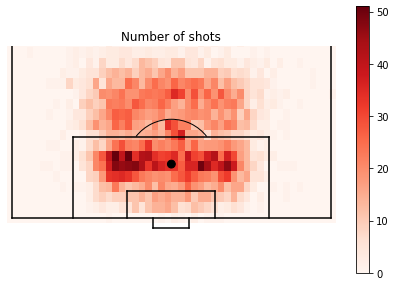

In [13]:
# Compute a two-dimensional histogram of shots from different points
shotcounts, _, _ = np.histogram2d(shots_model['X'], shots_model['Y'],
                                  bins=50, range=[[0, 100],[0, 100]])

# Plot the number of shots from different points
createGoalMouth()
pos = plt.imshow(shotcounts, extent=[-1,66,104,-1], cmap=plt.cm.Reds)
plt.colorbar(pos)
plt.title('Number of shots')
plt.show()

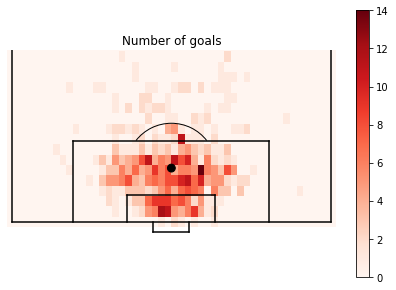

In [14]:
# Compute a two-dimensional histogram of goals from different points
goals_only = shots_model[shots_model['Goal'] == 1]
goalcounts, _, _ = np.histogram2d(goals_only['X'], goals_only['Y'],
                                  bins=50, range=[[0, 100],[0, 100]])

# Plot the number of goals from different points
createGoalMouth()
pos = plt.imshow(goalcounts, extent=[-1,66,104,-1], cmap=plt.cm.Reds)
plt.colorbar(pos)
plt.title('Number of goals')
plt.show()

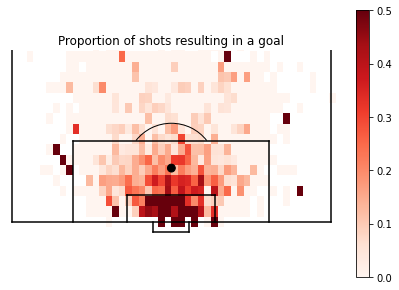

In [15]:
# Compute empirical probability of scoring from different points
with np.errstate(divide='ignore', invalid='ignore'):
    prob_goal = goalcounts / shotcounts

# Plot the probability of scoring from different points.
createGoalMouth()
pos = plt.imshow(prob_goal, extent=[-1,66,104,-1], cmap=plt.cm.Reds,
                 vmin=0, vmax=0.5)
plt.colorbar(pos)
plt.title('Proportion of shots resulting in a goal')
plt.show()

## b)
The code below plots how shot angle determine probability of scoring. It fits a logistic regression model and compares it to data. Make a similar plot for distance to goal. See what happens when you add distance squared.

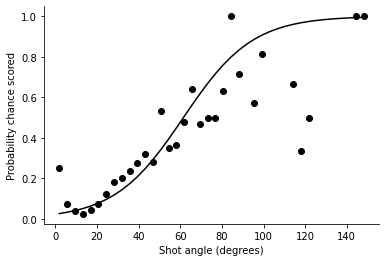

In [16]:
# Make single variable model of angle
# Using logistic regression we find the optimal parameters
X = shots_model[['Angle']]
y = shots_model['Goal']
model = skl_lm.LogisticRegression(penalty='none')
model.fit(X, y)

# Bin the angles of shots to compute empirical estimates of the
# probabilities of goals scored
shotcount_angle, bin_edges = np.histogram(shots_model['Angle'] * 180 / np.pi, bins=40, range=[0, 150])
goalcount_angle, _ = np.histogram(goals_only['Angle'] * 180 / np.pi, bins=40, range=[0, 150])

# Compute average angle in each bin
angle = (bin_edges[:-1] + bin_edges[1:])/2

# Empirical estimate of probabilities of goal scored
# for bins with at least one shot
ibins = np.where(shotcount_angle > 0)
prob_goal = goalcount_angle[ibins] / shotcount_angle[ibins]

# Compute predictions
xGprob = model.predict_proba(angle.reshape(-1, 1) * np.pi / 180) 

# Plot data and predictions
plt.plot(angle[ibins], prob_goal, 'ko')
plt.plot(angle, xGprob[:,1], 'k')
plt.xlabel("Shot angle (degrees)")
plt.ylabel('Probability chance scored')
plt.show()

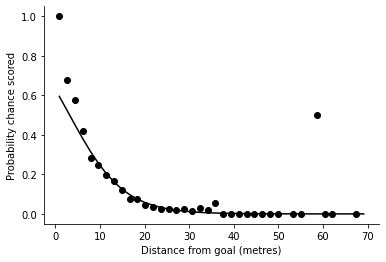

In [17]:
#<keep>
#Show empirically how distance from goal predicts probability of scoring
#</keep>

# Bin the distances of shots to compute empirical estimates of the
# probabilities of goals scored
shotcount_dist, bin_edges = np.histogram(shots_model['Distance'], bins=40, range=[0, 70])
goalcount_dist, _ = np.histogram(goals_only['Distance'], bins=40, range=[0, 70])

# Compute average distance in each bin
distance = (bin_edges[:-1] + bin_edges[1:])/2

# Empirical estimate of probabilities of goal scored
# for bins with at least one shot
ibins = np.where(shotcount_dist > 0)
prob_goal = goalcount_dist[ibins] / shotcount_dist[ibins]

# Plot data
plt.plot(distance[ibins], prob_goal, 'ko')
plt.xlabel("Distance from goal (metres)")
plt.ylabel('Probability chance scored')

#<keep>
#Make single variable model of distance
#</keep>
X = shots_model[['Distance']]
y = shots_model['Goal']
model = skl_lm.LogisticRegression(penalty='none')
model.fit(X, y)

# Compute predictions and plot them
xGprob = model.predict_proba(distance.reshape(-1, 1))
plt.plot(distance, xGprob[:,1], 'k')
plt.show()

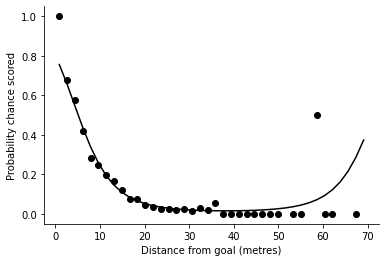

In [18]:
#<keep>
#Adding distance squared
#</keep>
shots_model['D2'] = shots_model['Distance']**2

# Fit logistic regression model
X = shots_model[['Distance', 'D2']]
y = shots_model['Goal']
model = skl_lm.LogisticRegression(penalty='none')
model.fit(X, y)

# Compute predictions
X_test = np.column_stack([distance, distance**2])
xGprob = model.predict_proba(X_test)

# Plot data and predictions
plt.plot(distance[ibins], prob_goal, 'ko')
plt.plot(distance, xGprob[:,1], 'k')
plt.xlabel("Distance from goal (metres)")
plt.ylabel('Probability chance scored')
plt.show()

## c)
By setting `model_variables` in the code below you can test different features. Investigate manually which parameters work best. 

The number of parameters is: 2
The log-likelihood is: -2010.671
The AIC is: 4025.341


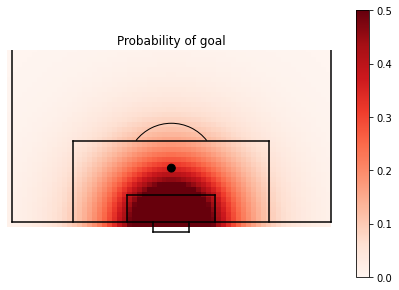

In [19]:
# Adding even more variables to the model.
shots_model['X2'] = shots_model['X']**2
shots_model['C2'] = shots_model['C']**2
shots_model['AX'] = shots_model['Angle']*shots_model['X']

# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['Distance']

# Fit the linear regression model.
X = shots_model[model_variables]
y = shots_model['Goal']
model = skl_lm.LogisticRegression(penalty='none')
model.fit(X, y)

# Number of parameters of logistic regression model
k = model.coef_.size + model.get_params()['fit_intercept']
print(f'The number of parameters is: {k:d}')
    
# Compute maximum log-likelihood
n = y.size
loglik = np.sum(np.log(model.predict_proba(X)[np.arange(n), y]))
print(f'The log-likelihood is: {loglik:.3f}')

# Compute AIC
AIC = 2 * (k - loglik)
print(f'The AIC is: {AIC:.3f}')

# Create a 2D map of predicted probabilities
pgoal_2d = np.zeros((65,65))
for x in range(65):
    for y in range(65):
        # Compute features for this field
        sh = dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a < 0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        # Compute predictions
        X_field = np.array([sh[var] for var in model_variables]).reshape(1, -1)
        pgoal_2d[x, y] = model.predict_proba(X_field)[:, 1]

# Plot model
createGoalMouth()
plt.imshow(pgoal_2d, extent=[-1,65,65,-1],
           cmap=plt.cm.Reds, vmin=0, vmax=0.3)
plt.colorbar(pos)
plt.title('Probability of goal')
plt.show()